<a href="https://colab.research.google.com/github/kode-git/FER-Visual-Transformers/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation

Models evaluation notebook, to test and retrieves basics metrics for model comparisons. 

## Install Dependencies and Import Libraries

In [1]:
!pip install timm
!git clone https://github.com/davda54/sam.git

     |████████████████████████████████| 431 kB 4.4 MB/s 
Cloning into 'sam'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 179 (delta 62), reused 53 (delta 53), pack-reused 104
Receiving objects: 100% (179/179), 650.16 KiB | 4.22 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [2]:
# classic libraries for collections.
import pandas as pd
import numpy as np

# utility library.
import random, time, copy

# plot libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# libraries for image processing.
import os, cv2, glob, imageio, sys
from PIL import Image
# warning library for service warnings.
import warnings

# machine learning libraries .
import timm, torch, torchvision
from torchsummary import summary

# image dataset loading and transformations.
from torchvision import datasets, models, transforms

# utility functions for specific uses.
from __future__ import print_function
from __future__ import division

# optimizer libraries.
from torch.optim import lr_scheduler
import torch.optim as optim
from sam.sam import SAM

# library for basic building blocks.
import torch.nn as nn

# library for saving and loading checkpoints.
import pickle

# libraries for metrics and evaluation phase.
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# colab library.
from google.colab import drive

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


In [4]:
# load Google Drive environment.
drive.mount('/content/drive')

Mounted at /content/drive


## GPU Configuration

In [5]:
!nvidia-smi

Sun May 15 20:58:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Detect if we have a GPU available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Common utilities

In [7]:
# setup variables
input_size = (224,224)
batch_size = 60
NUM_CLASSES = 8

In [8]:
def mkdir_model(base_dir, name_model, counter):
  """
  Making a directory for the model dump.
  """
  try:
    d = "{}/{}".format(base_dir,name_model)
    os.mkdir(d)
  except FileExistsError:
    counter += 1
    mkdir_model(base_dir, str(name_model) + "_" + str(counter), counter)

def save_history(history, filename):
  """
  Save the history in the file.
  """
  if os.path.isfile(filename):
    os.remove(filename)
  file_handler = open(filename + ".pkl", "wb")
  pickle.dump(history, file_handler)
  file_handler.close()


def load_history(filename):
  """
  Load the history from the file.
  """
  file_handler = open(filename + ".pkl", "rb")
  output = pickle.load(file_handler)
  file_handler.close()
  return output



def multi_plot(curves, num_epochs, labels = [], fig_size=(16,5), xlabel="Epochs", ylabel="", title="Plot", stepx_size = 1, vert_size = None):
  """
  Defines a plot with multiple curves.
  """
  ran = list(range(1, num_epochs + 1, stepx_size)) # 1 to num_epochs on x axes
  plt.figure(figsize=fig_size)
  plt.subplot(1,len(curves), 1)
  plt.xlim(1, num_epochs)
  plt.ylim(0, vert_size)
  if len(curves) != len(labels):
    raise IndexError('Curves size don\'t match with labels: {} -> {}'.format(len(curves), len(labels)))
  if not len(curves) or len(curves) > 4:
    raise IndexError('Curves collection oversize or downsize, support plot until 4 lines but curves has size of {}'.format(len(curves)))
  colors = ['b', 'g', 'r', 'c']
  for i in range(len(curves)):
    plt.plot(ran, curves[i], marker='o', linestyle='--', color=colors[i], label=labels[i])

  # metadata.
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()

  # plot showing.
  plt.show()


def tensor_to_list(tensor_list):
  """
  Given a list or a tensor, return the list. 
  """
  l = []
  try:
    # Tensor support.
    for el in tensor_list:
      l.append(el.item())
  except AttributeError:
    # Case of simple list.
    for el in tensor_list:
      l.append(el)
  return l

def test_model(model, dataloaders,   
                is_loaded = False, load_state_ws=None,
                  model_folder=""):
    """
    Pytorch testing function
    """
    final_scores = []
    overall_labels = []
    if is_loaded and load_state_ws != None:
      # load the model
      state_dict = torch.load(load_state_ws)
      model.load_state_dict(state_dict)
      model.eval()
      print('Model loaded correctly')
      print("Testing phase start...")
      total = len(dataloaders['test'])
      model = model.eval()   # Set model to evaluate mode
      dl = dataloaders['test']
      totalIm=0
      running_corrects = 0
      # Iterate over data.
      for inputs, labels in dl:
          totalIm+=len(inputs)
          inputs = inputs.to(device)
          labels = labels.to(device)
          # forward
          # track history if only in train
          with torch.set_grad_enabled(False):
              scores = model(inputs)
              #c oncatenating final scores and label list
              final_scores=[*final_scores,*scores.tolist()]
              overall_labels=[*overall_labels,*labels.tolist()]
        

    return final_scores,overall_labels

## Loading testing set

In [ ]:
data_dir= "/content/drive/MyDrive/Datasets/VFER/"
data_transforms_test = {
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Create training and validation datasets
image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_test[x]) for x in ['test']}

# Create training and validation dataloaders
dataloaders_dict_test = {x: torch.utils.data.DataLoader(image_datasets_test[x], batch_size=batch_size, shuffle=False, num_workers=2,pin_memory=True) for x in [ 'test']}

## ResNet-18 evaluation

### Training evaluation

In [73]:
# load history divided by steps
steps = [25]
base_dir = "/content/drive/MyDrive/Models/"
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for step in steps:
  name_model = "resnet18_" + str(step)
  model_folder = base_dir + name_model + "/"
  train_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_train"))
  val_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_val"))
  step_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
  train_loss += step_loss['train']
  val_loss += step_loss['val']

In [74]:
# we need to merge them together.
for i in range(len(train_accuracy)):
  train_accuracy[i] = round(train_accuracy[i], 6)
  val_accuracy[i] = round(val_accuracy[i], 6)
  val_loss[i] = round(val_loss[i], 6)
  train_loss[i] = round(train_loss[i], 6)

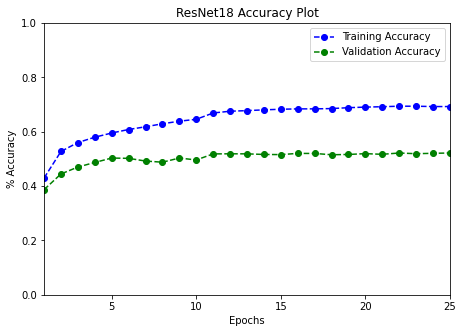

In [75]:
# accuracy evaluation.
multi_plot([train_accuracy, val_accuracy], 25, labels=['Training Accuracy', 'Validation Accuracy'], title="ResNet18 Accuracy Plot", ylabel="% Accuracy" )

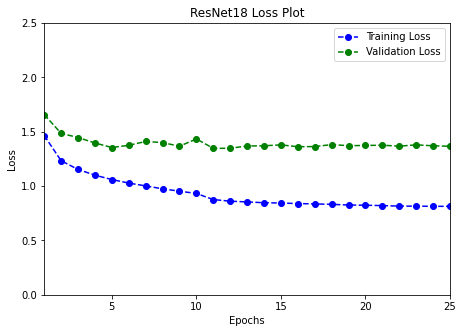

In [76]:
multi_plot([train_loss, val_loss], 25, labels=['Training Loss', 'Validation Loss'], title="ResNet18 Loss Plot", ylabel="Loss", vert_size=2.5 )

### Testing on AffectNet

In [ ]:
# setting the path of the model to be imported.
model_path='/content/drive/MyDrive/Models/resnet18_25/resnet18_25.pth'
model = timm.create_model('resnet18', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model,input_size=(3, 224, 224))
model.fc = nn.Linear(512, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU.
model = model.to(device)
scores,labels = test_model(model, dataloaders_dict_test, True, load_state_ws=model_path)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

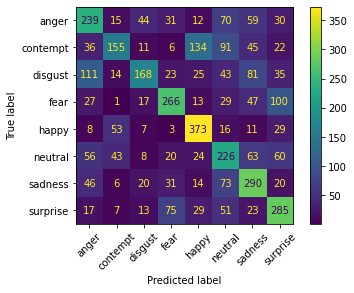

In [ ]:
# confusion matrix display.
y_true = labels
y_pred= np.argmax(scores,1)
categories = ["anger", "contempt", "disgust", "fear", "happy", "neutral", "sadness", "surprise"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(xticks_rotation=45)

In [ ]:
test_accuracy_8 = accuracy_score(y_true, y_pred, normalize=True)
y_true_7 = []
y_pred_7 = []
for i in range(len(y_true)):
  if y_true[i] != 1:
    y_true_7.append(y_true[i])
    y_pred_7.append(y_pred[i])
test_accuracy_7 = accuracy_score(y_true_7, y_pred_7, normalize=True)
print('Test Accuracy on AffectNet with 8-classes: {}'.format(round(test_accuracy_8,4)))
print('Test Accuracy on AffectNet with 7-classes: {}'.format(round(test_accuracy_7,4)))
print(metrics.classification_report(y_true, y_pred, digits=4, target_names=categories))

Test Accuracy on AffectNet with 8-classes: 0.5005


## ViT-B/16/S evaluation

### Training evaluation

In [62]:
# load history divided by steps
steps = [25]
base_dir = "/content/drive/MyDrive/Models/"
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for step in steps:
  name_model = "vfer_small_" + str(step)
  model_folder = base_dir + name_model + "/"
  train_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_train"))
  val_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_val"))
  step_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
  train_loss += step_loss['train']
  val_loss += step_loss['val']

In [63]:
# we need to merge them together.
for i in range(len(train_accuracy)):
  train_accuracy[i] = round(train_accuracy[i], 6)
  val_accuracy[i] = round(val_accuracy[i], 6)
  val_loss[i] = round(val_loss[i], 6)
  train_loss[i] = round(train_loss[i], 6)

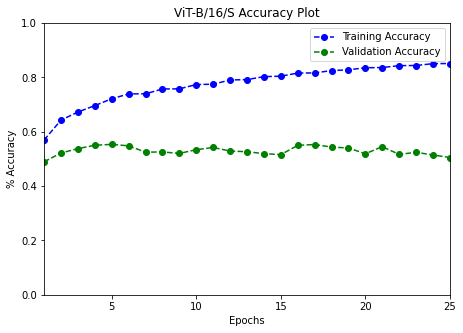

In [64]:
# accuracy evaluation.
multi_plot([train_accuracy, val_accuracy], 25, labels=['Training Accuracy', 'Validation Accuracy'], title="ViT-B/16/S Accuracy Plot", ylabel="% Accuracy" )

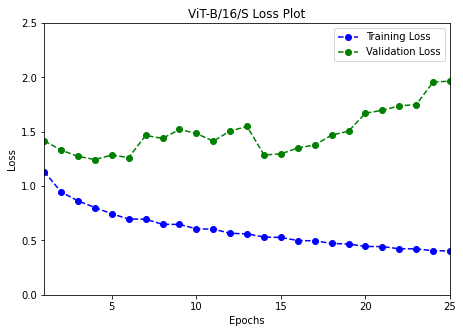

In [66]:
multi_plot([train_loss, val_loss], 25, labels=['Training Loss', 'Validation Loss'], title="ViT-B/16/S Loss Plot", ylabel="Loss", vert_size=2.5 )

### Testing on AffectNet

In [ ]:
# setting the path of the model to be imported
model_path='/content/drive/MyDrive/Models/vfer_small_25/vfer_small_25.pth'

model = timm.create_model('vit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model,input_size=(3, 224, 224))
model.head = nn.Linear(768, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)
scores,labels = test_model(model, dataloaders_dict_test, True, load_state_ws=model_path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

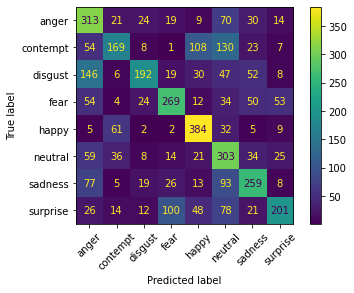

In [ ]:
y_true = labels
y_pred= np.argmax(scores,1)
categories = ["anger","contempt","disgust","fear","happy","neutral","sadness","surprise"]

# labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(xticks_rotation=45)

In [ ]:
test_accuracy_8 = accuracy_score(y_true, y_pred, normalize=True)
y_true_7 = []
y_pred_7 = []
for i in range(len(y_true)):
  if y_true[i] != 1:
    y_true_7.append(y_true[i])
    y_pred_7.append(y_pred[i])
test_accuracy_7 = accuracy_score(y_true_7, y_pred_7, normalize=True)
print('Test Accuracy on AffectNet with 8-classes: {}'.format(round(test_accuracy_8,4)))
print('Test Accuracy on AffectNet with 7-classes: {}'.format(round(test_accuracy_7,4)))
print(metrics.classification_report(y_true, y_pred, digits=4, target_names=categories))

Test Accuracy on AffectNet with 8-classes: 0.5225
Test Accuracy on AffectNet with 7-classes: 0.5489
              precision    recall  f1-score   support

       anger     0.4264    0.6260    0.5073       500
    contempt     0.5348    0.3380    0.4142       500
     disgust     0.6644    0.3840    0.4867       500
        fear     0.5978    0.5380    0.5663       500
       happy     0.6144    0.7680    0.6827       500
     neutral     0.3850    0.6060    0.4709       500
     sadness     0.5464    0.5180    0.5318       500
    surprise     0.6185    0.4020    0.4873       500

    accuracy                         0.5225      4000
   macro avg     0.5485    0.5225    0.5184      4000
weighted avg     0.5485    0.5225    0.5184      4000



## ViT-B/16/SG evaluation

### Training Evaluation

In [80]:
# load history divided by steps
steps = [25]
base_dir = "/content/drive/MyDrive/Models/"
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for step in steps:
  name_model = "vfer_grad_" + str(step)
  model_folder = base_dir + name_model + "/"
  train_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_train"))
  val_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_val"))
  step_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
  train_loss += step_loss['train']
  val_loss += step_loss['val']

In [81]:
# we need to merge them together.
for i in range(len(train_accuracy)):
  train_accuracy[i] = round(train_accuracy[i], 6)
  val_accuracy[i] = round(val_accuracy[i], 6)
  val_loss[i] = round(val_loss[i], 6)
  train_loss[i] = round(train_loss[i], 6)

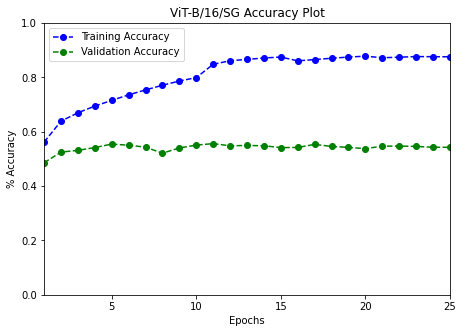

In [82]:
# accuracy evaluation.
multi_plot([train_accuracy, val_accuracy], 25, labels=['Training Accuracy', 'Validation Accuracy'], title="ViT-B/16/SG Accuracy Plot", ylabel="% Accuracy" )

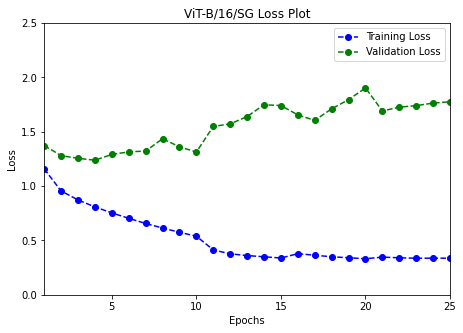

In [84]:
multi_plot([train_loss, val_loss], 25, labels=['Training Loss', 'Validation Loss'], title="ViT-B/16/SG Loss Plot", ylabel="Loss", vert_size=2.5 )

### Testing on AffectNet

In [ ]:
# setting the path of the model to be imported
model_path='/content/drive/MyDrive/Models/vfer_grad_25/vfer_grad_25.pth'

model = timm.create_model('vit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model,input_size=(3, 224, 224))
model.head = nn.Linear(768, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)
scores,labels = test_model(model, dataloaders_dict_test, True, load_state_ws=model_path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

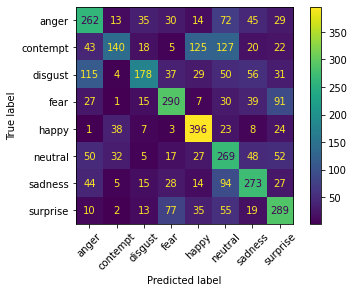

In [ ]:
y_true = labels
y_pred= np.argmax(scores,1)
categories = ["anger","contempt","disgust","fear","happy","neutral","sadness","surprise"]

# labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(xticks_rotation=45)

In [ ]:
test_accuracy_8 = accuracy_score(y_true, y_pred, normalize=True)
y_true_7 = []
y_pred_7 = []
for i in range(len(y_true)):
  if y_true[i] != 1:
    y_true_7.append(y_true[i])
    y_pred_7.append(y_pred[i])
test_accuracy_7 = accuracy_score(y_true_7, y_pred_7, normalize=True)
print('Test Accuracy on AffectNet with 8-classes: {}'.format(round(test_accuracy_8,4)))
print('Test Accuracy on AffectNet with 7-classes: {}'.format(round(test_accuracy_7,4)))
print(metrics.classification_report(y_true, y_pred, digits=4, target_names=categories))

Test Accuracy on AffectNet with 8-classes: 0.5242
Test Accuracy on AffectNet with 7-classes: 0.5591
              precision    recall  f1-score   support

       anger     0.4746    0.5240    0.4981       500
    contempt     0.5957    0.2800    0.3810       500
     disgust     0.6224    0.3560    0.4529       500
        fear     0.5955    0.5800    0.5876       500
       happy     0.6121    0.7920    0.6905       500
     neutral     0.3736    0.5380    0.4410       500
     sadness     0.5374    0.5460    0.5417       500
    surprise     0.5115    0.5780    0.5427       500

    accuracy                         0.5242      4000
   macro avg     0.5404    0.5242    0.5169      4000
weighted avg     0.5404    0.5242    0.5169      4000



## ViT-B/16/SAM evaluation

### Training Evaluation

In [85]:
# load history divided by steps
steps = [25]
base_dir = "/content/drive/MyDrive/Models/"
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for step in steps:
  name_model = "vfer_sam_" + str(step)
  model_folder = base_dir + name_model + "/"
  train_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_train"))
  val_accuracy += tensor_to_list(load_history(model_folder + name_model + "_history_val"))
  step_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
  train_loss += step_loss['train']
  val_loss += step_loss['val']

In [88]:
# we need to merge them together.
for i in range(len(train_accuracy)):
  train_accuracy[i] = round(train_accuracy[i], 6)
  val_accuracy[i] = round(val_accuracy[i], 6)
  val_loss[i] = round(val_loss[i], 6)
  train_loss[i] = round(train_loss[i], 6)

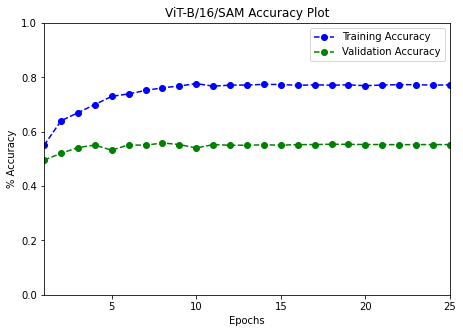

In [89]:
# accuracy evaluation.
multi_plot([train_accuracy, val_accuracy], 25, labels=['Training Accuracy', 'Validation Accuracy'], title="ViT-B/16/SAM Accuracy Plot", ylabel="% Accuracy" )

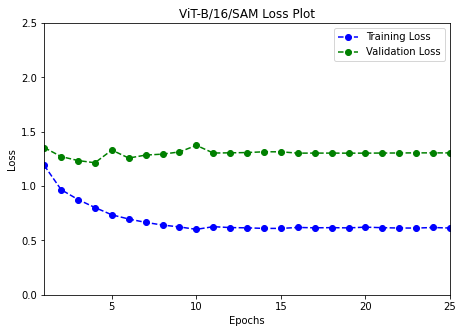

In [90]:
multi_plot([train_loss, val_loss], 25, labels=['Training Loss', 'Validation Loss'], title="ViT-B/16/SAM Loss Plot", ylabel="Loss", vert_size=2.5 )

### Testing on AffectNet

In [ ]:
# setting the path of the model to be imported
model_path='/content/drive/MyDrive/Models/vfer_sam_25/vfer_sam_25.pth'

model = timm.create_model('vit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model,input_size=(3, 224, 224))
model.head = nn.Linear(768, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)
scores,labels = test_model(model, dataloaders_dict_test, True, load_state_ws=model_path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

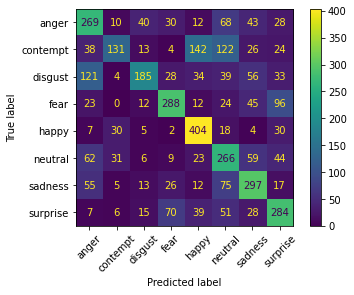

In [ ]:
y_true = labels
y_pred= np.argmax(scores,1)
categories = ["anger","contempt","disgust","fear","happy","neutral","sadness","surprise"]

# labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(xticks_rotation=45)

In [ ]:
test_accuracy_8 = accuracy_score(y_true, y_pred, normalize=True)
y_true_7 = []
y_pred_7 = []
for i in range(len(y_true)):
  if y_true[i] != 1:
    y_true_7.append(y_true[i])
    y_pred_7.append(y_pred[i])
test_accuracy_7 = accuracy_score(y_true_7, y_pred_7, normalize=True)
print('Test Accuracy on AffectNet with 8-classes: {}'.format(round(test_accuracy_8,4)))
print('Test Accuracy on AffectNet with 7-classes: {}'.format(round(test_accuracy_7,4)))
print(metrics.classification_report(y_true, y_pred, digits=4, target_names=categories))

Test Accuracy on AffectNet with 8-classes: 0.531
Test Accuracy on AffectNet with 7-classes: 0.5694
              precision    recall  f1-score   support

       anger     0.4622    0.5380    0.4972       500
    contempt     0.6037    0.2620    0.3654       500
     disgust     0.6401    0.3700    0.4689       500
        fear     0.6302    0.5760    0.6019       500
       happy     0.5959    0.8080    0.6859       500
     neutral     0.4012    0.5320    0.4574       500
     sadness     0.5323    0.5940    0.5614       500
    surprise     0.5108    0.5680    0.5379       500

    accuracy                         0.5310      4000
   macro avg     0.5470    0.5310    0.5220      4000
weighted avg     0.5470    0.5310    0.5220      4000



## Conclusions

In [96]:
# load training statistics.
steps = [25]
base_dir = "/content/drive/MyDrive/Models/"
models = ['resnet18','vfer_small', 'vfer_grad', 'vfer_sam']
step_loss = []
train_acc = {'resnet18' : [],'vfer_small' : [], 'vfer_grad' : [], 'vfer_sam' : []}
val_acc = {'resnet18' : [],'vfer_small' : [], 'vfer_grad' : [], 'vfer_sam' : []}
train_loss = {'resnet18' : [],'vfer_small' : [], 'vfer_grad' : [], 'vfer_sam' : []}
val_loss ={'resnet18' : [],'vfer_small' : [], 'vfer_grad' : [], 'vfer_sam' : []}
for model in models:
  for step in steps:
    name_model = model + "_" + str(step)
    model_folder = base_dir + name_model + "/"
    train_acc[model] += tensor_to_list(load_history(model_folder + name_model + "_history_train"))
    val_acc[model] += tensor_to_list(load_history(model_folder + name_model + "_history_val"))
    step_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
    train_loss[model] += step_loss['train']
    val_loss[model] += step_loss['val']

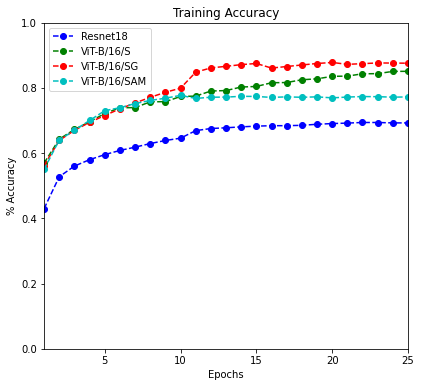

In [98]:
# training accuracy.
multi_plot([train_acc[mod] for mod in models], 25, labels=['Resnet18', 'ViT-B/16/S', 'ViT-B/16/SG', 'ViT-B/16/SAM'], title="Training Accuracy", ylabel="% Accuracy", vert_size=1, fig_size=(30,6) )

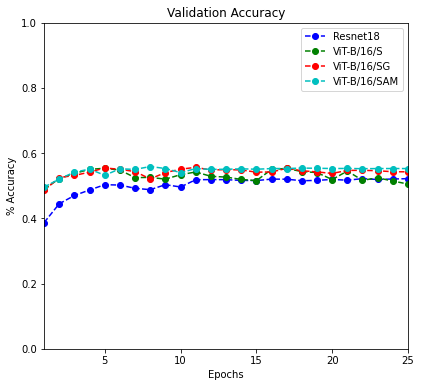

In [100]:
# validation accuracy.
multi_plot([val_acc[mod] for mod in models], 25, labels=['Resnet18', 'ViT-B/16/S', 'ViT-B/16/SG', 'ViT-B/16/SAM'], title="Validation Accuracy", ylabel="% Accuracy", vert_size=1, fig_size=(30,6) )

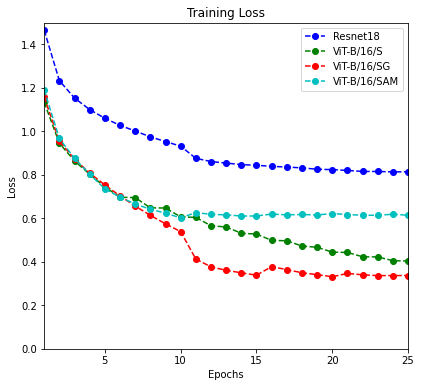

In [105]:
# training loss
multi_plot([train_loss[mod] for mod in models], 25, labels=['Resnet18', 'ViT-B/16/S', 'ViT-B/16/SG', 'ViT-B/16/SAM'], title="Training Loss", ylabel="Loss", vert_size=1.5, fig_size=(30,6) )

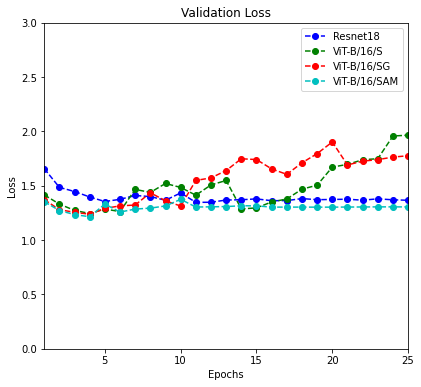

In [106]:
# validation loss
multi_plot([val_loss[mod] for mod in models], 25, labels=['Resnet18', 'ViT-B/16/S', 'ViT-B/16/SG', 'ViT-B/16/SAM'], title="Validation Loss", ylabel="Loss", vert_size=3, fig_size=(30,6) )